In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Get Data

In [28]:
breath_df = pd.read_pickle('breath_pickle')
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [29]:
# Use subset of data for now
under2 = under2[0:100]

## Define Split Trace Function

In [30]:
# Test split trace function is working properly
t = [1,2,3, 4,5, 6, 7, 8, 9, 10]
split_trace(t, 3, 3)

(array([[1, 2, 3]]), array([[4, 5, 6]]))

In [31]:
split_trace(t, 2, 5)

(array([[1, 2]]), array([[3, 4, 5, 6, 7]]))

In [32]:
split_trace(t, 1, 2)

(array([[1],
        [4],
        [7]]),
 array([[2, 3],
        [5, 6],
        [8, 9]]))

## Create Windowed Data

In [33]:
num_outputs=10

In [34]:
df = create_windowed_data(n_steps=100, num_outputs=num_outputs, dataset=under2['Trace'])

In [35]:
df.head()

,Trace,Next_pts,Trace_num
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...",0
1,"[0.3615, 0.3665, 0.3716, 0.3767, 0.3818, 0.386...","[0.7242, 0.7252, 0.7261, 0.7269, 0.7277, 0.728...",0
2,"[0.7313, 0.7318, 0.7323, 0.7328, 0.7334, 0.733...","[0.545, 0.5408, 0.5365, 0.5323, 0.5281, 0.5238...",0
3,"[0.5024, 0.4981, 0.4939, 0.4896, 0.4853, 0.481...","[0.1148, 0.1121, 0.1095, 0.107, 0.1045, 0.1021...",0
4,"[0.0905, 0.0882, 0.086, 0.0838, 0.0815, 0.0794...","[-0.0428, -0.0428, -0.0428, -0.0428, -0.0428, ...",0


## Train Val Test Split

In [36]:
df['Trace_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [37]:
train = df[df['Trace_num']>=51]
valid = df[(df['Trace_num']>=40) & (df['Trace_num']<51)]
test = df[df['Trace_num']<40]

In [38]:
X_train = train['Trace']
y_train = train['Next_pts']

X_val = valid['Trace']
y_val = valid['Next_pts']

X_test = test['Trace']
y_test = test['Next_pts']

## Scale Data

In [39]:
scaler = StandardScaler()
# Fit
scaler.fit(list(X_train))
# Transform
x_train = scaler.transform(list(X_train))
x_val = scaler.transform(list(X_val))
x_test = scaler.transform(list(X_test))

In [40]:
print(x_train.shape, x_val.shape, x_test.shape)

(2929, 100) (745, 100) (2139, 100)


##  Reshape Data

In [41]:
def reshape_trace(trace):
    trace = np.transpose(trace)
    return trace.reshape(trace.shape[0],trace.shape[1], 1)

In [42]:
x_train = reshape_trace(x_train)
x_val = reshape_trace(x_val)
x_test = reshape_trace(x_test)

In [43]:
print(x_train.shape, x_val.shape, x_test.shape)

(100, 2929, 1) (100, 745, 1) (100, 2139, 1)


In [44]:
y_train2 = reshape_trace(list(y_train))
y_val2 = reshape_trace(list(y_val))
y_test2 = reshape_trace(list(y_test))

In [45]:
print(y_train2.shape, y_val2.shape, y_test2.shape)

(10, 2929, 1) (10, 745, 1) (10, 2139, 1)


## Define Dataset

In [46]:
#dataset
from torch.utils.data import Dataset

In [47]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [48]:
type(x_train[0])

numpy.ndarray

In [49]:
dataset = timeseries(x_train,y_train2)
test_dataset = timeseries(x_val,y_val2)
final_test_dataset = timeseries(x_test,y_val2)

In [50]:
dataset.x.shape

torch.Size([100, 2929, 1])

In [51]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [24]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [25]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [26]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iteraations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Train a model

In [27]:
# mymodel = lstm_seq2seq(input_size=1, hidden_size=5)
# print(f'Model Details - Hidden Size {5} \t Learning Rate: {0.001}')
# train_loss = mymodel.train_model(dataset.x, dataset.y, n_epochs = 75, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)
# modname = 'lstm_encode_decode_' + '10_2'
# torch.save(mymodel, modname)

In [28]:
mod = lstm_seq2seq(input_size=1, hidden_size=5)
mod = torch.load('lstm_encode_decode_10')

## Plots

In [29]:
# test_preds = gather_preds(mod, final_test_dataset, num_outputs)
# valid_preds = gather_preds(mod, test_dataset, num_outputs)
# train_preds = gather_preds(mod, dataset, num_outputs)

In [30]:
# train['preds'] = train_preds
# valid['preds'] = valid_preds
# test['preds'] = test_preds

In [31]:
# train.to_pickle("train_df_10.pkl")  
# valid.to_pickle("valid_df_10.pkl")  
# test.to_pickle("test_df_10.pkl")  

In [32]:
train = pd.read_pickle("train_df_10.pkl") 
valid = pd.read_pickle("valid_df_10.pkl")  
test = pd.read_pickle("test_df_10.pkl")  

In [33]:
train.head()

,Trace,Next_pts,Trace_num,preds
2884,"[0.0002, 0.0006, 0.001, 0.0017, 0.0025, 0.0037...","[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...",51,"[0.6244346, 0.78482115, 0.84233636, 0.86007154..."
2885,"[0.8512, 0.8611, 0.8708, 0.8804, 0.89, 0.8996,...","[1.6863, 1.6936, 1.7007, 1.7076, 1.7144, 1.721...",51,"[1.6243749, 1.7197967, 1.7307901, 1.7218907, 1..."
2886,"[1.7524, 1.7583, 1.7641, 1.7697, 1.7753, 1.780...","[1.6931, 1.6811, 1.6689, 1.6567, 1.6444, 1.632...",51,"[1.6267244, 1.7131957, 1.7192359, 1.7070143, 1..."
2887,"[1.5745, 1.5638, 1.5535, 1.5433, 1.5332, 1.523...","[0.6415, 0.6328, 0.6241, 0.6154, 0.6068, 0.598...",51,"[0.51108366, 0.6484889, 0.69085413, 0.69504315..."
2888,"[0.556, 0.5477, 0.5394, 0.5312, 0.523, 0.5148,...","[0.1155, 0.1246, 0.1339, 0.1433, 0.1529, 0.162...",51,"[-0.02034083, 0.074667625, 0.113527276, 0.1280..."


In [34]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [35]:
train_pred_trace = train.groupby('Trace_num')['preds'].apply(list)
valid_pred_trace = valid.groupby('Trace_num')['preds'].apply(list)
test_pred_trace = test.groupby('Trace_num')['preds'].apply(list)

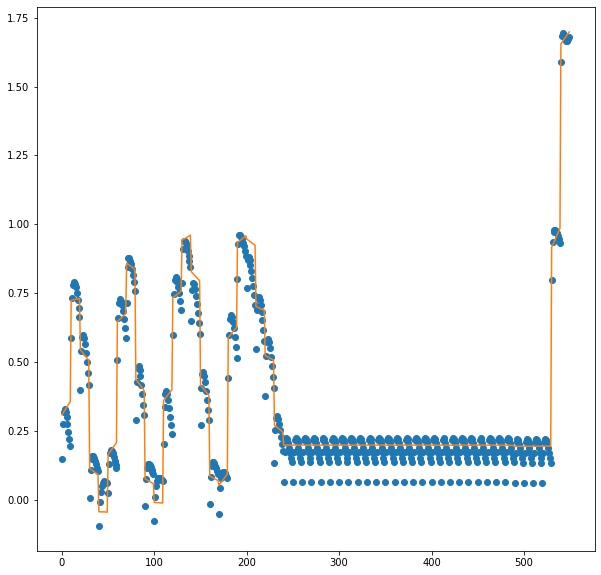

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
trace = np.concatenate(test_pred_trace[0]).ravel().tolist()
plt.plot(trace, 'o')

trace = np.concatenate(test_full_traces[0]).ravel().tolist()
plt.plot(trace, '-')
plt.show()

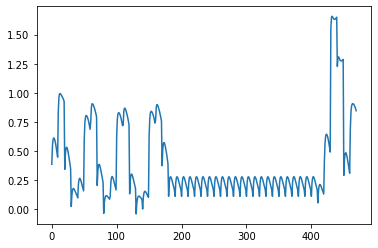

In [37]:
trace = np.concatenate(test_pred_trace[10]).ravel().tolist()
plt.plot(trace)
plt.show()

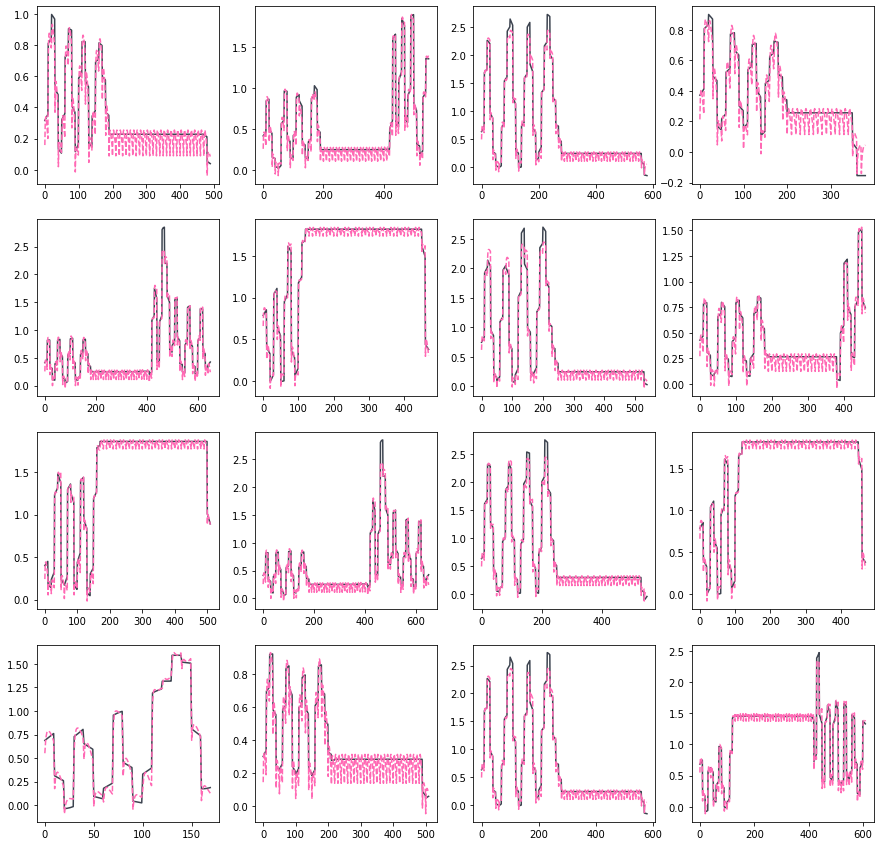

In [38]:
reconstruct_trace(test_full_traces, test_pred_trace)

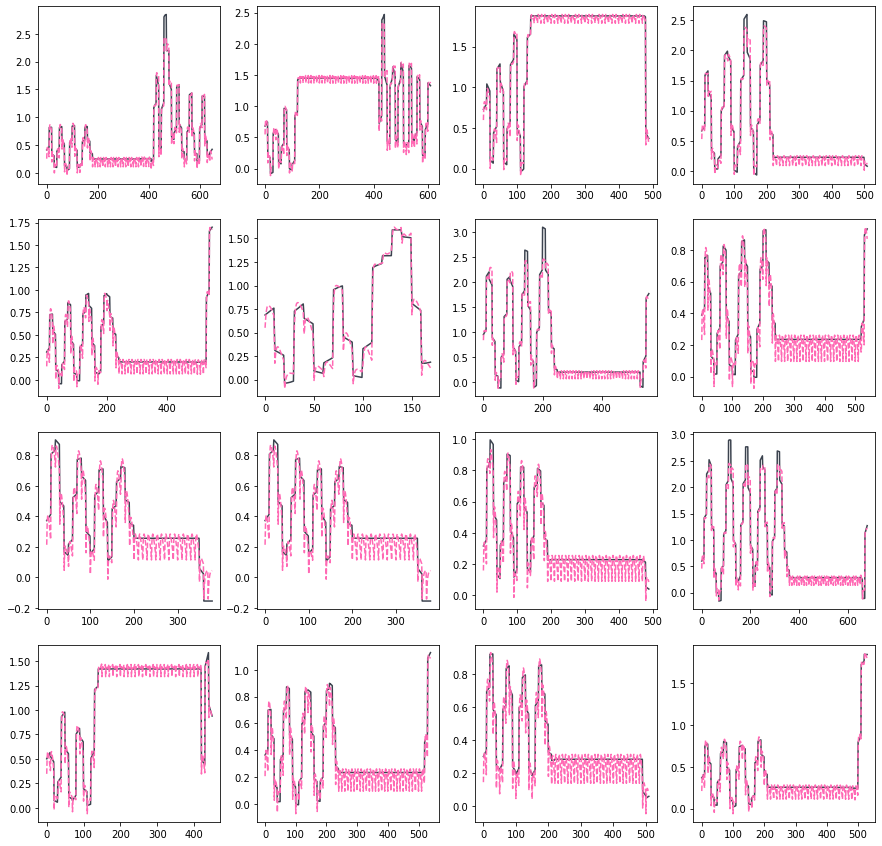

In [39]:
reconstruct_trace(test_full_traces, test_pred_trace)

# Error Plots

In [92]:
# sliding window
# reduce dimensionality cnn

In [69]:
errors = {}
for i in range(10):
    errors[i] = []

In [84]:
for i in range(len(test_pred_trace)):
    print(len(test_pred_trace[i]))

55
53
54
54
54
54
50
46
43
61
47
55
60
65
108
46
50
47
51
49
49
63
56
54
55
51
58
56
68
55
17
61
40
55
65
45
51
49
38
51


In [91]:
test_pred_trace[1][10]

array([-0.0616229 ,  0.02857451,  0.06779683,  0.085677  ,  0.09215398,
        0.09248123,  0.08955827,  0.08503928,  0.07988875,  0.07467017],
      dtype=float32)

In [78]:
for i in range(len(test_pred_trace)):
    for j in range(10):
        err = np.abs(test_full_traces[i][j]-test_pred_trace[i][j])
        print(err)
        errors[j].append(err)

[0.1597242  0.04010668 0.00073561 0.00422981 0.0110617  0.03609908
 0.06605732 0.0981513  0.13038902 0.16168109]
[0.13619232 0.00878048 0.05551982 0.06427503 0.0576247  0.04290342
 0.02241468 0.00316745 0.03353435 0.06838024]
[0.14646381 0.00041163 0.05385    0.06601733 0.05870569 0.04048234
 0.01489544 0.01609325 0.05116844 0.08883893]
[0.10745676 0.00410807 0.03816966 0.05354392 0.05528422 0.05004036
 0.04155818 0.0318921  0.0221256  0.01303152]
[0.05181656 0.03405613 0.07365109 0.09448525 0.10482819 0.10917924
 0.11039277 0.10956991 0.10791701 0.10578924]
[0.13928074 0.04038401 0.00484338 0.00233638 0.00491671 0.01933673
 0.0371654  0.05612539 0.0750559  0.09313674]
[0.14054686 0.00960124 0.06086397 0.07067698 0.06239033 0.04396081
 0.01845837 0.01288259 0.04908901 0.08991516]
[0.14266121 0.01269686 0.02271342 0.02631807 0.01934439 0.00745028
 0.0079698  0.02696973 0.04958278 0.07587284]
[0.14591    0.00416547 0.04880512 0.0608516  0.05274308 0.03339252
 0.00731519 0.02295327 0.0553

In [61]:
test_pred_trace[0][0]

array([0.1497758 , 0.27479333, 0.32103562, 0.32992983, 0.3199383 ,
       0.30010092, 0.2752427 , 0.2482487 , 0.22101097, 0.19481891],
      dtype=float32)

In [ ]:
test_full_traces, test_pred_trace